The purpose of this notebook is to test several machine learning models in our problem, trying to improve the TiC-Onco risk score results. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from utils import test_model, test_model_bootstrap

In [3]:
SEED = 1997 # for reproducibility

In [4]:
# reading data
path = 'data/'
data = pd.read_csv(path + 'data_TiC_Onco.csv')
X = data[data.columns.difference(['id','VTE','khorana'])]
y = data['VTE']
khorana = data['khorana']

X.shape, y.shape

((391, 9), (391,))

In [5]:
X.head()

,Family,bmi,estadiGrup,rs2232698,rs4524,rs5985,rs6025,tipusTumor_HR,tipusTumor_VHR
0,0,1,1,0,1,1,0,0,0
1,0,0,0,0,1,0,0,0,1
2,0,0,1,0,2,0,0,1,0
3,0,0,1,0,2,0,0,0,0
4,0,1,1,0,2,0,0,0,0


In [6]:
y.value_counts() 

0    318
1     73
Name: VTE, dtype: int64

### Baseline model (Logistic Regression)

In [7]:
lr = LogisticRegression(solver='liblinear', random_state=SEED)

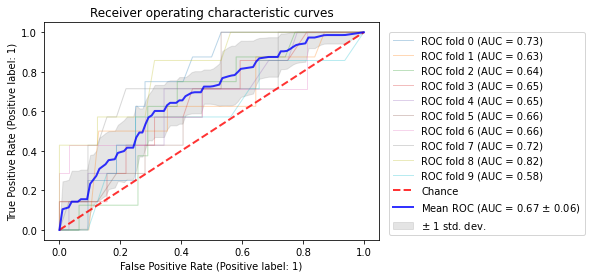

,score,mean,95% CI
0,AUC,0.67,"(0.55,0.8)"
1,accuracy,0.72,"(0.64,0.8)"
2,sensitivity,0.34,"(0.09,0.6)"
3,specificity,0.81,"(0.73,0.88)"
4,PPV,0.29,"(0.11,0.46)"
5,NPV,0.84,"(0.78,0.9)"


In [9]:
test_model(lr, X, y)

### Scaling data

In [10]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

scaler_std = StandardScaler()
X_scaled_std = scaler_std.fit_transform(X)

### Tunning Logistic Regression

In [28]:
lr = Pipeline([('LR',LogisticRegression(solver='liblinear', max_iter=10000, random_state=SEED))])

params_lr = {'LR__penalty': ['l1','l2'], 'LR__C': np.logspace(-4, 4, 50), 
          'LR__class_weight': [{1:0.5},{1:1},{1:5},{1:8},{1:10},{1:15},{1:20}]}


gs_lr = GridSearchCV(lr, params_lr, scoring='roc_auc', cv=10, n_jobs=2)
gs_lr.fit(X,y)
gs_lr.best_params_

{'LR__C': 0.0062505519252739694,
 'LR__class_weight': {1: 8},
 'LR__penalty': 'l2'}

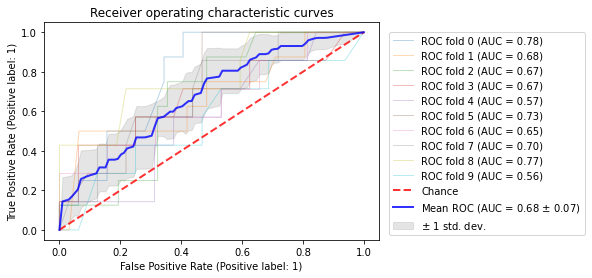

,score,mean,95% CI
0,AUC,0.68,"(0.54,0.82)"
1,accuracy,0.72,"(0.65,0.78)"
2,sensitivity,0.34,"(0.08,0.6)"
3,specificity,0.80,"(0.75,0.86)"
4,PPV,0.28,"(0.08,0.47)"
5,NPV,0.84,"(0.79,0.9)"


In [14]:
test_model(gs_lr.best_estimator_, X, y)

Adding MinMaxScaler:

In [32]:
lr = Pipeline([('scaler',MinMaxScaler()), ('LR',LogisticRegression(solver='liblinear', max_iter=10000, random_state=SEED))])

params_lr = {'LR__penalty': ['l1','l2'], 'LR__C': np.logspace(-4, 4, 50), 
          'LR__class_weight': [{1:0.5},{1:1},{1:5},{1:8},{1:10},{1:15},{1:20}]}


gs_lr = GridSearchCV(lr, params_lr, scoring='roc_auc', cv=10, n_jobs=2)
gs_lr.fit(X,y)
gs_lr.best_params_

{'LR__C': 0.0020235896477251557,
 'LR__class_weight': {1: 10},
 'LR__penalty': 'l2'}

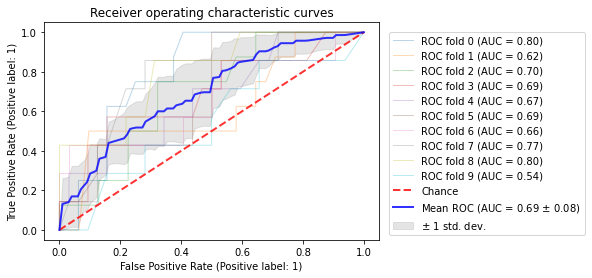

,score,mean,95% CI
0,AUC,0.69,"(0.54,0.85)"
1,accuracy,0.75,"(0.66,0.83)"
2,sensitivity,0.44,"(0.13,0.75)"
3,specificity,0.82,"(0.7,0.94)"
4,PPV,0.37,"(0.14,0.6)"
5,NPV,0.87,"(0.8,0.93)"


In [27]:
test_model(gs_lr.best_estimator_, X, y)

### LinearSVC

Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions.

In [25]:
lin_svc = Pipeline([('LinearSVC',LinearSVC(random_state=SEED, max_iter=10000, dual=False))])

params_lin_svc = {'LinearSVC__penalty': ['l1','l2'], 'LinearSVC__C': np.logspace(-4, 4, 50), 
          'LinearSVC__class_weight': [{1:0.5},{1:1},{1:5},{1:8},{1:10},{1:15},{1:20}]}


gs_lin_svc = GridSearchCV(lin_svc, params_lin_svc, scoring='roc_auc', cv=10, n_jobs=2)
gs_lin_svc.fit(X,y)
gs_lin_svc.best_params_

{'LinearSVC__C': 0.009102981779915217,
 'LinearSVC__class_weight': {1: 8},
 'LinearSVC__penalty': 'l1'}

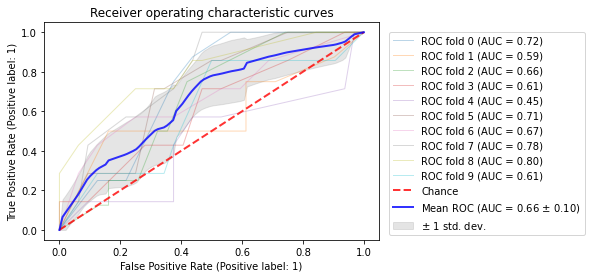

,score,mean,95% CI
0,AUC,0.66,"(0.46,0.86)"
1,accuracy,0.72,"(0.65,0.78)"
2,sensitivity,0.39,"(0.01,0.77)"
3,specificity,0.79,"(0.69,0.89)"
4,PPV,0.28,"(0.13,0.44)"
5,NPV,0.85,"(0.77,0.93)"


In [26]:
test_model(gs_lin_svc.best_estimator_, X, y)

In [33]:
lin_svc = Pipeline([('scaler',MinMaxScaler()), ('LinearSVC',LinearSVC(random_state=SEED, max_iter=10000, dual=False))])

params_lin_svc = {'LinearSVC__penalty': ['l1','l2'], 'LinearSVC__C': np.logspace(-4, 4, 50), 
          'LinearSVC__class_weight': [{1:0.5},{1:1},{1:5},{1:8},{1:10},{1:15},{1:20}]}


gs_lin_svc = GridSearchCV(lin_svc, params_lin_svc, scoring='roc_auc', cv=10, n_jobs=2)
gs_lin_svc.fit(X,y)
gs_lin_svc.best_params_

{'LinearSVC__C': 0.00014563484775012445,
 'LinearSVC__class_weight': {1: 8},
 'LinearSVC__penalty': 'l2'}

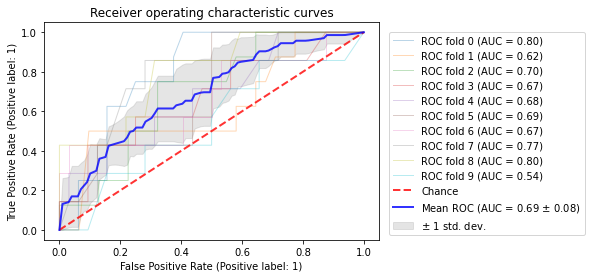

,score,mean,95% CI
0,AUC,0.69,"(0.54,0.84)"
1,accuracy,0.75,"(0.66,0.83)"
2,sensitivity,0.42,"(0.13,0.72)"
3,specificity,0.82,"(0.7,0.94)"
4,PPV,0.37,"(0.14,0.6)"
5,NPV,0.86,"(0.8,0.92)"


In [20]:
test_model(gs_lin_svc.best_estimator_, X, y)

### KNN Classifier

In [30]:
knn = Pipeline([('KNN',KNeighborsClassifier())])

params_knn = {'KNN__n_neighbors': np.linspace(3,299,num=75,dtype=int), 'KNN__weights': ['uniform','distance'], 
          'KNN__p': [1,2,3,4,5]}


gs_knn = GridSearchCV(knn, params_knn, scoring='roc_auc', cv=10, n_jobs=2)
gs_knn.fit(X,y)
gs_knn.best_params_

{'KNN__n_neighbors': 163, 'KNN__p': 1, 'KNN__weights': 'uniform'}

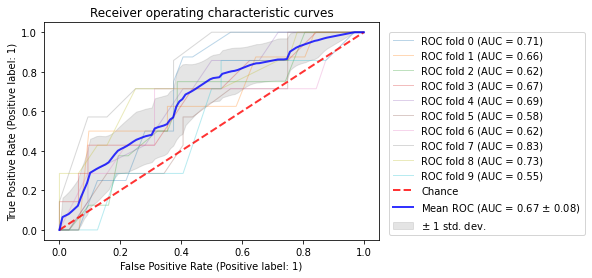

,score,mean,95% CI
0,AUC,0.67,"(0.51,0.82)"
1,accuracy,0.72,"(0.63,0.8)"
2,sensitivity,0.40,"(0.21,0.59)"
3,specificity,0.79,"(0.71,0.87)"
4,PPV,0.30,"(0.15,0.46)"
5,NPV,0.85,"(0.8,0.9)"


In [8]:
test_model(gs_knn.best_estimator_, X, y)

In [34]:
knn = Pipeline([('scaler',MinMaxScaler()), ('KNN',KNeighborsClassifier())])

params_knn = {'KNN__n_neighbors': np.linspace(3,299,num=75,dtype=int), 'KNN__weights': ['uniform','distance'], 
          'KNN__p': [1,2,3,4,5]}


gs_knn = GridSearchCV(knn, params_knn, scoring='roc_auc', cv=10, n_jobs=2)
gs_knn.fit(X,y)
gs_knn.best_params_

{'KNN__n_neighbors': 219, 'KNN__p': 2, 'KNN__weights': 'uniform'}

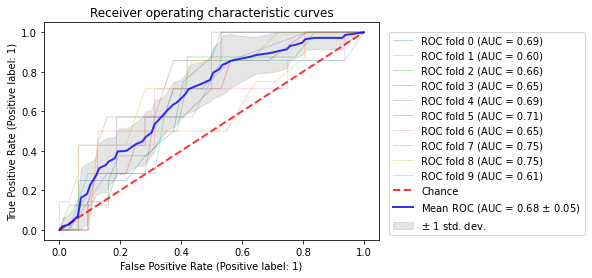

,score,mean,95% CI
0,AUC,0.68,"(0.58,0.77)"
1,accuracy,0.72,"(0.67,0.76)"
2,sensitivity,0.37,"(0.16,0.58)"
3,specificity,0.80,"(0.76,0.83)"
4,PPV,0.29,"(0.17,0.41)"
5,NPV,0.85,"(0.8,0.89)"


In [10]:
test_model(gs_knn.best_estimator_, X, y)

### Support Vector Machine

In [15]:
svc = Pipeline([('scaler',MinMaxScaler()), ('SVC',SVC(probability=True, random_state=SEED))])

params_svc = {'SVC__C': np.logspace(-4, 2, 10), 'SVC__kernel': ['poly','rbf'],
          'SVC__gamma': ['scale',0.1,1/9,0.15,0.2,0.3,0.4,0.5,0.6,0.8,1.0], 'SVC__class_weight': [{1:1},{1:5},{1:8},{1:10}]}


gs_svc = GridSearchCV(svc, params_svc, scoring='roc_auc', cv=10, n_jobs=2, verbose=2)
gs_svc.fit(X,y)
gs_svc.best_params_

Fitting 10 folds for each of 440 candidates, totalling 4400 fits


{'SVC__C': 0.01,
 'SVC__class_weight': {1: 5},
 'SVC__gamma': 0.1,
 'SVC__kernel': 'rbf'}

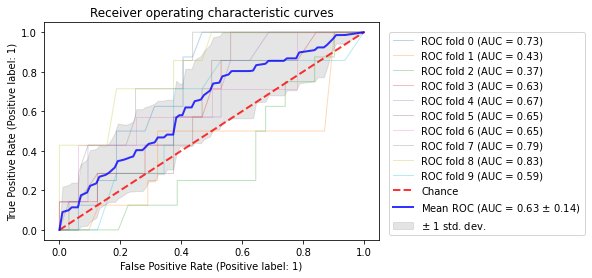

,score,mean,95% CI
0,AUC,0.63,"(0.36,0.91)"
1,accuracy,0.70,"(0.61,0.8)"
2,sensitivity,0.32,"(0,0.69)"
3,specificity,0.79,"(0.72,0.87)"
4,PPV,0.25,"(0.02,0.48)"
5,NPV,0.84,"(0.74,0.93)"


In [20]:
test_model(gs_svc.best_estimator_, X, y)

## Ensemble methods

### Bagging classifier

In [24]:
bagging = Pipeline([('Bagging',BaggingClassifier(random_state=SEED))])

params_bagging = {'Bagging__base_estimator': [DecisionTreeClassifier(random_state=SEED)], 
                  'Bagging__n_estimators': [5,10,15,20,25,30], 
                  'Bagging__max_samples': [0.5,0.6,0.7,0.8,0.9,1.0],
                  'Bagging__max_features': [0.2,0.3,0.5,0.8,1.0]}


gs_bagging = GridSearchCV(bagging, params_bagging, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_bagging.fit(X,y)
gs_bagging.best_params_

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


{'Bagging__base_estimator': DecisionTreeClassifier(random_state=1997),
 'Bagging__max_features': 0.5,
 'Bagging__max_samples': 0.9,
 'Bagging__n_estimators': 5}

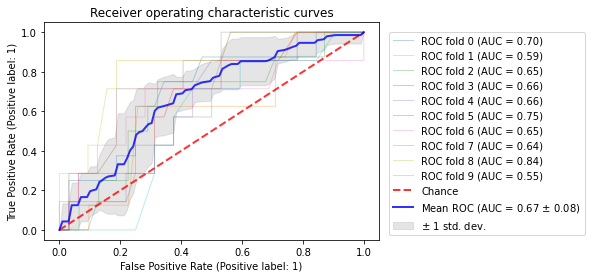

,score,mean,95% CI
0,AUC,0.67,"(0.52,0.82)"
1,accuracy,0.69,"(0.59,0.79)"
2,sensitivity,0.28,"(0,0.66)"
3,specificity,0.79,"(0.75,0.83)"
4,PPV,0.22,"(0,0.46)"
5,NPV,0.83,"(0.74,0.92)"


In [25]:
test_model(gs_bagging.best_estimator_, X, y)

Using Linear SVC as base estimator: bad performance ~ 0.55

Using Logistic Regression as base estimator:

In [38]:
base = gs_lr.best_estimator_
bagging = Pipeline([('scaler',MinMaxScaler()),('Bagging',BaggingClassifier(base_estimator=base, random_state=SEED))])

params_bagging = {'Bagging__n_estimators': [5,10,20,30,40,50], 
                  'Bagging__max_samples': [0.5,0.7,0.8,0.9,1.0],
                  'Bagging__max_features': [0.5,0.7,0.8,0.9,1.0]}


gs_bagging = GridSearchCV(bagging, params_bagging, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_bagging.fit(X,y)
gs_bagging.best_params_

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


{'Bagging__max_features': 0.9,
 'Bagging__max_samples': 0.8,
 'Bagging__n_estimators': 40}

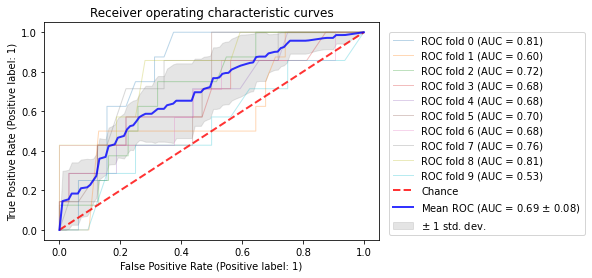

,score,mean,95% CI
0,AUC,0.70,"(0.53,0.86)"
1,accuracy,0.72,"(0.62,0.82)"
2,sensitivity,0.44,"(0.16,0.71)"
3,specificity,0.79,"(0.66,0.91)"
4,PPV,0.32,"(0.19,0.46)"
5,NPV,0.86,"(0.8,0.92)"


In [33]:
test_model(gs_bagging.best_estimator_, X, y)

Using best KNN as base estimator:

In [38]:
base = gs_knn.best_estimator_
bagging = Pipeline([('Bagging',BaggingClassifier(base_estimator=base, random_state=SEED))])

params_bagging = {'Bagging__n_estimators': [5,10,20,30,40,50], 
                  'Bagging__max_samples': [0.5,0.7,0.8,0.9,1.0],
                  'Bagging__max_features': [0.5,0.7,0.8,0.9,1.0]}


gs_bagging = GridSearchCV(bagging, params_bagging, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_bagging.fit(X,y)
gs_bagging.best_params_

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


{'Bagging__max_features': 0.7,
 'Bagging__max_samples': 0.8,
 'Bagging__n_estimators': 10}

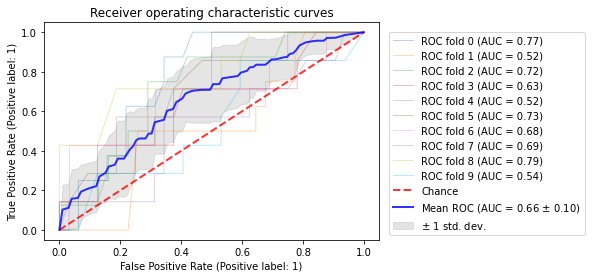

,score,mean,95% CI
0,AUC,0.66,"(0.46,0.85)"
1,accuracy,0.71,"(0.61,0.8)"
2,sensitivity,0.33,"(0,0.69)"
3,specificity,0.80,"(0.74,0.85)"
4,PPV,0.26,"(0.02,0.49)"
5,NPV,0.84,"(0.75,0.93)"


In [39]:
test_model(gs_bagging.best_estimator_, X, y)

### Random Forest

In [9]:
rf = Pipeline([('RF',RandomForestClassifier(random_state=SEED))])

params_rf = {'RF__n_estimators': [5,10,15,20,30,50], 'RF__max_depth': [None,2,3,5],
              'RF__max_features': ['sqrt',0.5,0.8], 'RF__max_samples': [0.5,0.8,1.0],
             'RF__class_weight': [{1:0.5},{1:1},{1:3},{1:5},{1:10}]}


gs_rf = GridSearchCV(rf, params_rf, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_rf.fit(X,y)
gs_rf.best_params_

Fitting 10 folds for each of 1080 candidates, totalling 10800 fits


C:\Users\ESAlvarePa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.52370032 0.53922001 0.53372426 ...        nan        nan        nan]
  warnings.warn(


{'RF__class_weight': {1: 3},
 'RF__max_depth': 3,
 'RF__max_features': 0.5,
 'RF__max_samples': 0.8,
 'RF__n_estimators': 5}

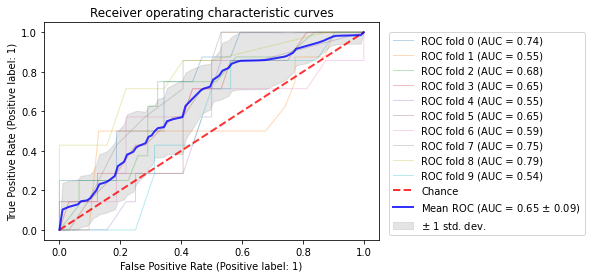

,score,mean,95% CI
0,AUC,0.65,"(0.47,0.82)"
1,accuracy,0.71,"(0.64,0.79)"
2,sensitivity,0.30,"(0,0.69)"
3,specificity,0.81,"(0.77,0.84)"
4,PPV,0.24,"(0,0.5)"
5,NPV,0.84,"(0.76,0.91)"


In [10]:
test_model(gs_rf.best_estimator_, X, y)

### Extra Trees

In [14]:
et = Pipeline([('ET',ExtraTreesClassifier(random_state=SEED))])

params_et = {'ET__n_estimators': [5,10,15,20,30,50], 'ET__max_depth': [None,2,3,5],
              'ET__max_features': ['sqrt',0.5,0.8],
             'ET__class_weight': [{1:0.5},{1:1},{1:3},{1:5},{1:10}]}


gs_et = GridSearchCV(et, params_et, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_et.fit(X,y)
gs_et.best_params_

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


{'ET__class_weight': {1: 10},
 'ET__max_depth': 2,
 'ET__max_features': 'sqrt',
 'ET__n_estimators': 5}

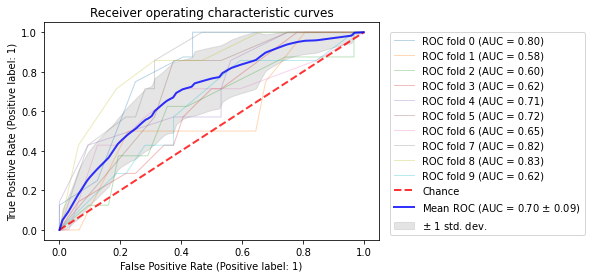

,score,mean,95% CI
0,AUC,0.70,"(0.51,0.88)"
1,accuracy,0.74,"(0.67,0.82)"
2,sensitivity,0.46,"(0.14,0.79)"
3,specificity,0.81,"(0.73,0.89)"
4,PPV,0.35,"(0.19,0.52)"
5,NPV,0.87,"(0.8,0.94)"


In [15]:
test_model(gs_et.best_estimator_, X, y)

### AdaBoost

In [20]:
ab = Pipeline([('AB',AdaBoostClassifier(random_state=SEED))])

params_ab = {'AB__n_estimators': [5,8,10,12,15,20,30,50,80,100],
              'AB__learning_rate': np.linspace(0.1, 2, num=20)}


gs_ab = GridSearchCV(ab, params_ab, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_ab.fit(X,y)
gs_ab.best_params_

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


{'AB__learning_rate': 1.5999999999999999, 'AB__n_estimators': 30}

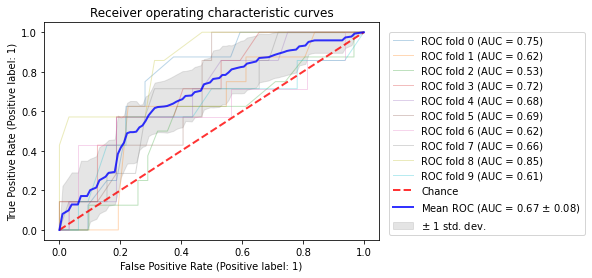

,score,mean,95% CI
0,AUC,0.67,"(0.51,0.84)"
1,accuracy,0.71,"(0.63,0.79)"
2,sensitivity,0.29,"(0,0.62)"
3,specificity,0.81,"(0.78,0.84)"
4,PPV,0.24,"(0.01,0.48)"
5,NPV,0.83,"(0.75,0.92)"


In [21]:
test_model(gs_ab.best_estimator_, X, y)

### Gradient Boosting 

In [22]:
gb = Pipeline([('GB',GradientBoostingClassifier(random_state=SEED))])

params_gb = {'GB__learning_rate': np.linspace(0.1, 2, num=20),
            'GB__n_estimators': [5,10,15,20,30,50], 
            'GB__max_features':['sqrt',0.5,0.8,1.0],
            'GB__subsample': [0.5,0.8,1.0], 'GB__max_depth': [2,3,5]}


gs_gb = GridSearchCV(gb, params_gb, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_gb.fit(X,y)
gs_gb.best_params_

Fitting 10 folds for each of 4320 candidates, totalling 43200 fits


{'GB__learning_rate': 0.2,
 'GB__max_depth': 2,
 'GB__max_features': 0.8,
 'GB__n_estimators': 15,
 'GB__subsample': 0.5}

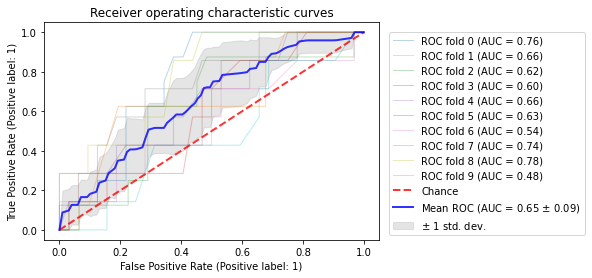

,score,mean,95% CI
0,AUC,0.65,"(0.47,0.83)"
1,accuracy,0.71,"(0.63,0.78)"
2,sensitivity,0.30,"(0,0.69)"
3,specificity,0.80,"(0.73,0.87)"
4,PPV,0.23,"(0,0.49)"
5,NPV,0.84,"(0.76,0.91)"


In [23]:
test_model(gs_gb.best_estimator_, X, y)

### Voting Classifier

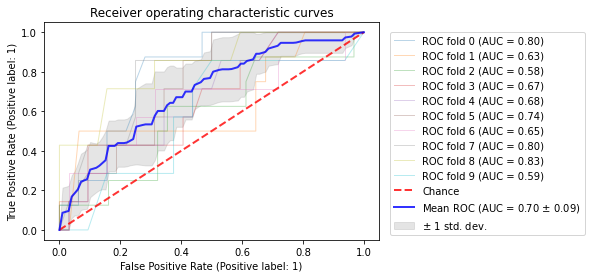

,score,mean,95% CI
0,AUC,0.70,"(0.52,0.87)"
1,accuracy,0.74,"(0.68,0.81)"
2,sensitivity,0.38,"(0.07,0.7)"
3,specificity,0.82,"(0.78,0.87)"
4,PPV,0.32,"(0.14,0.5)"
5,NPV,0.85,"(0.79,0.92)"


In [31]:
#estimators = [('lr',gs_lr.best_estimator_), ('knn',gs_knn.best_estimator_), ('bagging_lr',gs_bagging.best_estimator_)]
estimators = [('lr',gs_lr.best_estimator_), ('knn',gs_knn.best_estimator_), ('et',gs_et.best_estimator_)]

voting = VotingClassifier(estimators=estimators, voting='soft')

test_model(voting, X, y)

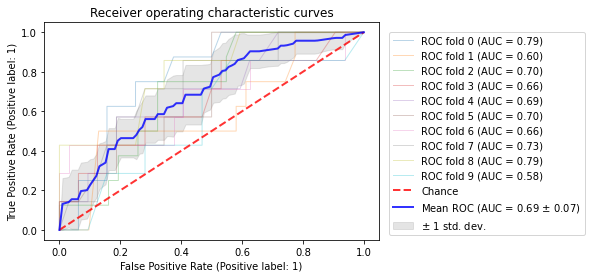

,score,mean,95% CI
0,AUC,0.69,"(0.56,0.82)"
1,accuracy,0.74,"(0.66,0.83)"
2,sensitivity,0.39,"(0.17,0.62)"
3,specificity,0.82,"(0.71,0.93)"
4,PPV,0.35,"(0.11,0.6)"
5,NPV,0.86,"(0.81,0.9)"


In [39]:
estimators = [('lr',gs_lr.best_estimator_), ('knn',gs_knn.best_estimator_), ('bagging_lr',gs_bagging.best_estimator_)]

voting = Pipeline([('scaler',MinMaxScaler()), ('voting',VotingClassifier(estimators=estimators, voting='soft'))])

test_model(voting, X, y)

### Stacking Classifier

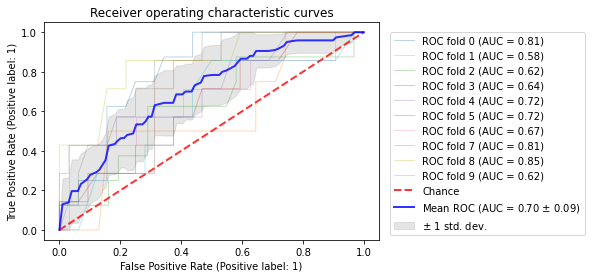

,score,mean,95% CI
0,AUC,0.70,"(0.53,0.88)"
1,accuracy,0.73,"(0.66,0.8)"
2,sensitivity,0.44,"(0.13,0.75)"
3,specificity,0.80,"(0.73,0.86)"
4,PPV,0.32,"(0.18,0.47)"
5,NPV,0.86,"(0.79,0.93)"


In [41]:
estimators = [('et',gs_et.best_estimator_), ('bagging_lr',gs_bagging.best_estimator_)]

stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
                              
test_model(stacking, X, y)

## Results:

|            Model            |      AUC     | accuracy | sensitivity | specificity |  PPV |  NPV |
|:---------------------------:|:------------:|:--------:|:-----------:|:-----------:|:----:|:----:|
|        LR                   | 0.68 +- 0.07 |   0.72   |     0.34    |     0.80    | 0.28 | 0.84 |
|        LR (scaled)          | 0.69 +- 0.08 |   0.75   |     0.44    |     0.82    | 0.37 | 0.87 |
|          Linear SVC         | 0.69 +- 0.08 |   0.72   |     0.39    |     0.79    | 0.28 | 0.85 |
|             KNN             | 0.67 +- 0.08 |   0.72   |     0.40    |     0.79    | 0.30 | 0.85 |
|             KNN (scaled)    | 0.68 +- 0.05 |   0.72   |     0.37    |     0.80    | 0.29 | 0.85 |
|             SVC             | 0.63 +- 0.14 |   0.70   |     0.32    |     0.79    | 0.25 | 0.84 |
|        Bagging              | 0.67 +- 0.08 |   0.69   |     0.28    |     0.79    | 0.22 | 0.83 |
|         Bagging (LR)        | 0.69 +- 0.08 |   0.72   |     0.44    |     0.79    | 0.32 | 0.86 |
|        Bagging (KNN)        | 0.66 +- 0.10 |   0.71   |     0.33    |     0.80    | 0.26 | 0.84 |
|        Random Forest        | 0.65 +- 0.09 |   0.71   |     0.30    |     0.81    | 0.24 | 0.84 |
|         Extra Trees         | 0.70 +- 0.09 |   0.74   |     0.46    |     0.81    | 0.35 | 0.87 |
|           AdaBoost          | 0.67 +- 0.08 |   0.71   |     0.29    |     0.81    | 0.24 | 0.83 |
|        Grad. Boosting       | 0.65 +- 0.09 |   0.71   |     0.30    |     0.80    | 0.23 | 0.84 |
| Voting (LR+KNN+ET)         | 0.70 +- 0.09 |   0.74   |     0.38    |     0.82    | 0.32 | 0.85 |
| Voting (LR+KNN+bagging_lr) | 0.69 +- 0.07 |   0.74   |     0.39    |     0.82    | 0.35 | 0.86 |
|  Stacking (ET+bagging_lr)  | 0.70 +- 0.09 |   0.73   |     0.44    |     0.80    | 0.32 | 0.86 |

In [13]:
# best model
clf = KNeighborsClassifier(n_neighbors=163, p=1)

In [25]:
test_model_bootstrap(clf, X, y)

,score,mean,95% CI
0,AUC,0.69,"(0.61,0.77)"
1,accuracy,0.73,"(0.69,0.77)"
2,sensitivity,0.43,"(0.27,0.58)"
3,specificity,0.80,"(0.77,0.83)"
4,PPV,0.33,"(0.22,0.43)"
5,NPV,0.86,"(0.82,0.9)"
